<a href="https://colab.research.google.com/github/kskksg4/HiDTTimeLapse/blob/main/HiDTTimeLapse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/saic-mdal/HiDT.git

Cloning into 'HiDT'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 374 (delta 1), reused 4 (delta 1), pack-reused 369
Receiving objects: 100% (374/374), 173.69 MiB | 24.39 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [2]:
import sys

sys.path.extend(['/content/HiDT', '/content/HiDT/hidt'])

In [5]:
import torch
import matplotlib.pyplot as plt

from PIL import Image
from hidt.networks.enhancement.RRDBNet_arch import RRDBNet
from hidt.style_transformer import StyleTransformer
from hidt.utils.preprocessing import GridCrop, enhancement_preprocessing

In [6]:
config_path = '/content/HiDT/configs/daytime.yaml'
gen_weights_path = '/content/HiDT/trained_models/generator/daytime.pt'
device = 'cuda'

style_transformer = StyleTransformer(
    config_path,
    gen_weights_path,
    inference_size=256, # output image size
    device=device
)

(2048, 1162)


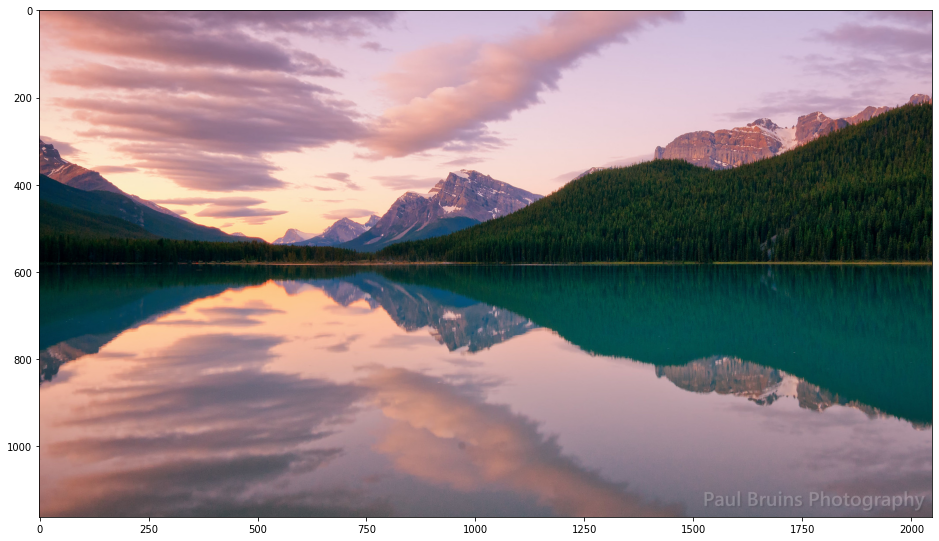

In [8]:
img_path = '/content/HiDT/images/daytime/content/1.jpg'
img = Image.open(img_path)

print(img.size)
plt.figure(figsize=(16, 10))
plt.imshow(img)

In [11]:
from pprint import pprint

with open('/content/HiDT/styles.txt') as f:
    styles = f.read()

styles = {style.split(',')[0]: torch.tensor([float(el) for el in style.split(',')[1][1:-1].split(' ')]) for style in styles.split('\n')[:-1]}

pprint(styles)

{'2minute': tensor([-0.3823,  0.5701, -0.9534]),
 '5minute': tensor([ 0.0393, -0.4581, -0.3173]),
 '5minutes2': tensor([-0.1544, -0.5920, -0.3295]),
 'another_night': tensor([ 0.0071, -1.3750, -0.3271]),
 'bluehour_bit_dark': tensor([-0.2956, -1.5699, -0.5350]),
 'bluehour_hard': tensor([ 0.4088, -1.6698,  0.2443]),
 'darknight': tensor([-0.4466, -1.3072, -0.3449]),
 'day': tensor([-0.2403,  0.4950,  0.2264]),
 'day2': tensor([-0.1528, -1.3118,  1.5012]),
 'hard_day': tensor([-0.0228, -0.3949,  0.8980]),
 'night': tensor([-0.4951, -1.0065, -1.0413]),
 'night2': tensor([-0.1531, -1.5918,  0.0850]),
 'nightmore': tensor([ 0.1075, -1.4487, -0.1843]),
 'onemorenight': tensor([ 0.2080, -1.5224, -0.0414]),
 'presunset': tensor([-0.2966,  0.5421, -0.6357]),
 'semihard_day': tensor([-0.1316,  0.0501,  0.5622]),
 'sunset_hard_harder': tensor([-0.5931,  1.0843, -1.2714]),
 'sunsetred': tensor([-0.1542,  0.1676, -1.7730])}


In [12]:
style_to_transfer = styles['bluehour_hard']
style_to_transfer = style_to_transfer.view(1, 1, 3, 1).to(device)

(256, 448, 3)


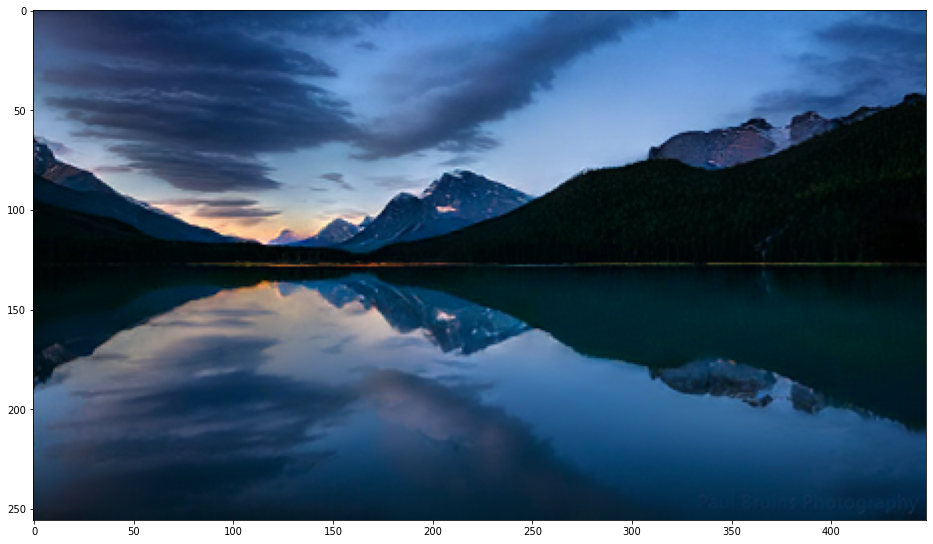

In [13]:
with torch.no_grad():
    content_decomposition = style_transformer.get_content(img)[0]

    decoder_input = {
        'content': content_decomposition['content'],
        'intermediate_outputs': content_decomposition['intermediate_outputs'],
        'style': style_to_transfer
    }

    transferred = style_transformer.trainer.gen.decode(decoder_input)['images']
    
output_img = (transferred[0].cpu().clamp(-1, 1).numpy().transpose(1, 2, 0) + 1.) / 2.

print(output_img.shape)
plt.figure(figsize=(16, 10))
plt.imshow(output_img)

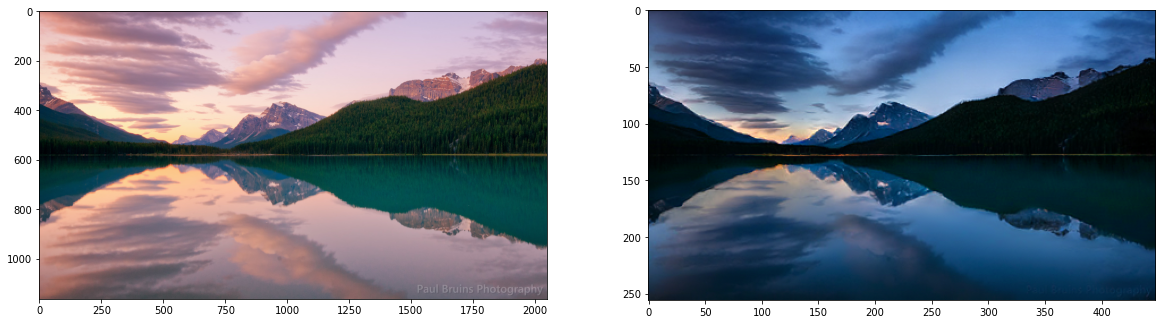

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img)
axes[1].imshow(output_img)

In [16]:
enhancer_weights = '/content/HiDT/trained_models/enhancer/enhancer.pth'
enhancer = RRDBNet(in_nc=48, out_nc=3, nf=64, nb=5 ,gc=32).to(device)
enhancer.load_state_dict(torch.load(enhancer_weights))

crop_transfrom = GridCrop(4, 1, hires_size=256 * 4)
crops = [img for img in crop_transfrom(img)]

print(len(crops))

16


In [18]:
with torch.no_grad():
  crops = [i for i in crop_transfrom(img)]
  content_decomposition = style_transformer.get_content(crops)[0]

  decoder_input = {
      'content': content_decomposition['content'],
      'intermediate_outputs': content_decomposition['intermediate_outputs'],
      'style': style_to_transfer.repeat(16, 1, 1, 1)
  }

  transferred = style_transformer.trainer.gen.decode(decoder_input)['images']

  padded_stack = enhancement_preprocessing(transferred, normalize=False)
  out = enhancer(padded_stack)

enhanced_output_img = (out.cpu()[0].clamp(-1, 1).numpy().transpose(1, 2, 0) + 1.) / 2.

(1024, 1792, 3)


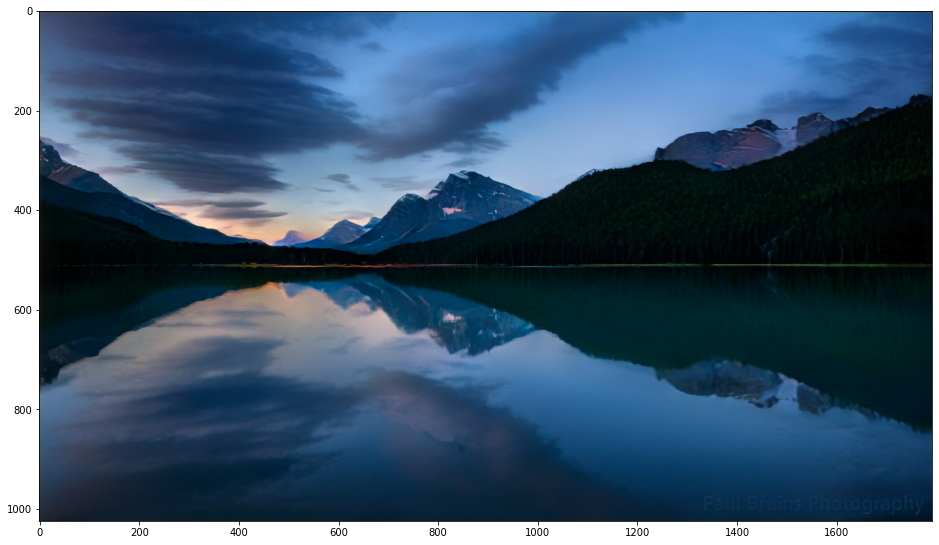

In [19]:
print(enhanced_output_img.shape)

plt.figure(figsize=(16, 10))
plt.imshow(enhanced_output_img)

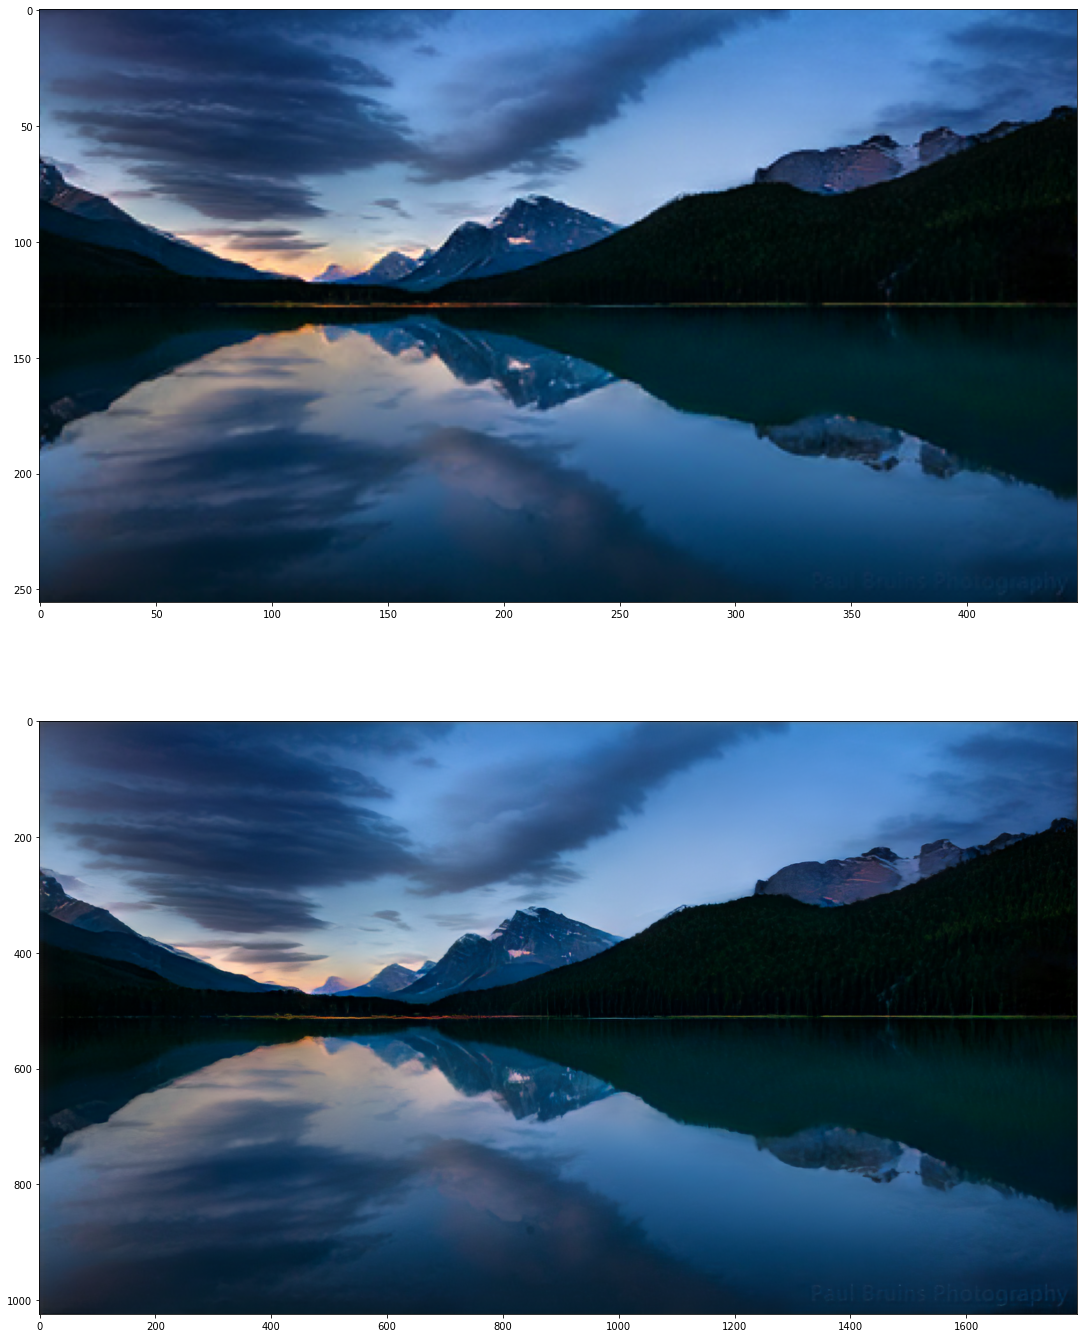

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(20, 24))
axes[0].imshow(output_img)
axes[1].imshow(enhanced_output_img)

In [23]:
def transfer(img, style):
  style_to_transfer = styles[style]
  style_to_transfer = style_to_transfer.view(1, 1, 3, 1).to(device)

  with torch.no_grad():
    content_decomposition = style_transformer.get_content(img)[0]

    decoder_input = {
        'content': content_decomposition['content'],
        'intermediate_outputs': content_decomposition['intermediate_outputs'],
        'style': style_to_transfer
    }

    transferred = style_transformer.trainer.gen.decode(decoder_input)['images']

  return (transferred[0].cpu().clamp(-1, 1).numpy().transpose(1, 2, 0) + 1.) / 2.

In [24]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


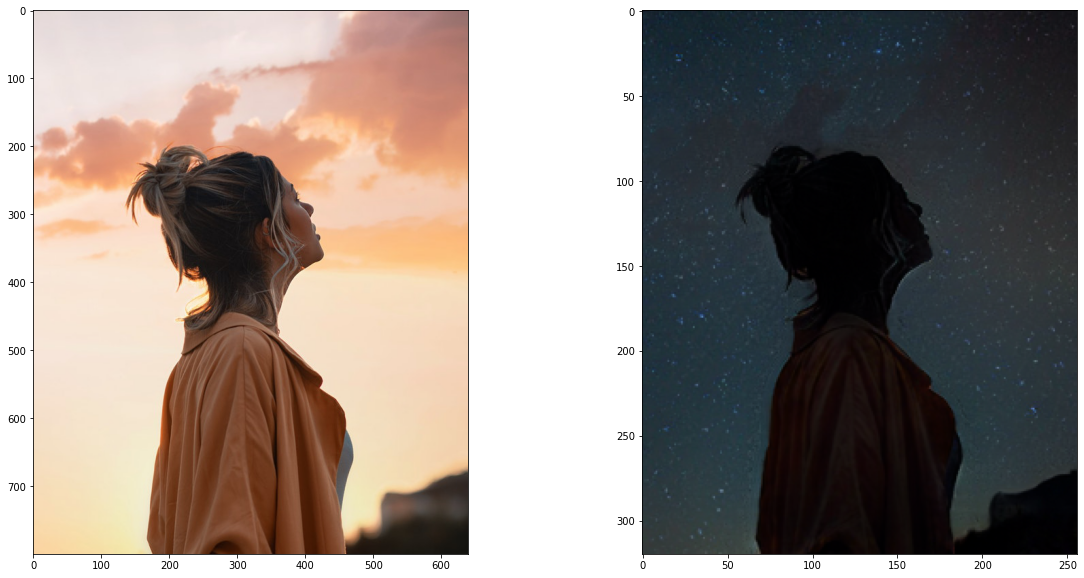

In [27]:
test_img = Image.open('/content/gdrive/My Drive/DeepLearning/HIDT(timelaps)/test_img/01.jpg')
transfer_test_img = transfer(test_img, 'night')
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(test_img)
axes[1].imshow(transfer_test_img)

In [30]:
print('test_img :', test_img.size)
print('transfer_test_img :', test_img.size)

test_img : (640, 800)
transfer_test_img : (640, 800)
